# 问题1

Q: 使用原始的人工神经元（如图10-3中的一个）来计算神经网络，计算 $A\oplus B$ 。提示： $A \oplus B = (A \cap \neg B) \cup (\neg A \cap B)$

4 ->(3) C

4(改) ->(3) C

# 问题2

Q: 为什么通常使用逻辑回归分类器而不是经典感知器？你如何调整感知器使之等同于逻辑回归分类器？

A: <span style="color: red">感知器只适用于数据是线性可分的。</span>因为逻辑回归能够输出每一类别的概率，而感知器不能。把阶跃函数换成sigmid函数(<span style="color: red">或softmax函数</span>)。

# 问题3

Q: 为什么激活函数是训练第一个MLP的关键因素？

A: 因为阶跃函数，导数为0，不能运用梯度下降进行训练。(<span style="color: red">也就是梯度不能移动</span>)

# 问题4

Q: 说出三种流行的激活函数。你能画出它们吗？

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def sigmoid(X):
    return 1 / (1 + np.exp(-X))


def relu(X):
    return np.maximum(X, 0)


def tanh(X):
    return 2 * sigmoid(2 * X) - 1

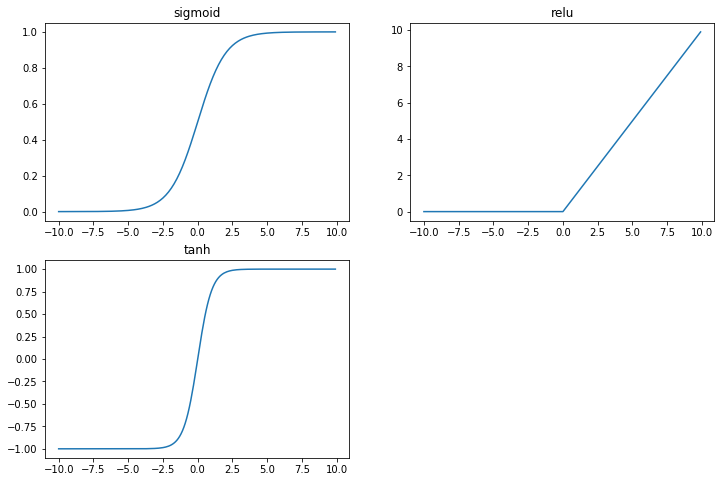

In [2]:
X = range(-100, 100)
X = np.array([i / 10 for i in X])
plt.figure(22, figsize=(12, 8))
plt.subplot(221)
plt.plot(X, sigmoid(X), label="sigmoid")
plt.title("sigmoid")
plt.subplot(222)
plt.plot(X, relu(X), label="relu")
plt.title("relu")
plt.subplot(223)
plt.plot(X, tanh(X), label="tanh")
_ = plt.title("tanh")

<span style="color: red">还有ELU和ReLU变种</span>

# 问题5

Q: 假设有一个MLP有一个10个神经元组成的输入层，接着是一个50个神经元的隐藏层，最后一个3个神经元输出层。所有人工神经元使用Relu激活函数。
- 输入矩阵 X 的形状是什么？
- 隐藏层的权重向量的形状以及它的偏置向量的形状如何？
- 输出层的权重向量和他的偏置向量的形状是什么？
- 网络的输出矩阵 Y 是什么形状？
- 写出计算网络输出矩阵的方程

A: 解
- (None, 10)
- W1: (10, 50), b1: (1, 50)
- W2: (50, 3), b2: (1, 3)
- Y_hat: (3, 1)(<span style="color: red">(None, 3)</span>)
- $Z = \text{Relu}(X \cdot W_1 + b_1), \hat{y} = \text{Relu}(Z \cdot W_2 + b_2)$

# 问题6

Q: 如果你想把电子邮件分类成垃圾邮件或正常邮件，你需要在输出层中有多少个神经元? 在输出层中应该使用什么样的激活函数?如果你想解决 MNIST 问题，你需要多少神经元在输出层，使用什么激活函数?如第 2 章，一样让你的网络预测房屋价格。

A: 2个(<span style="color: red">1个就够了</span>)。sigmoid或softmax(<span style="color: red">logistic function</span>)。10个。softmax。那么就不使用激活函数了。

# 问题7

Q: 什么是反向传播，它是如何工作的?反向传播与反向自动微分有什么区别?

A: 使用正向传播的预测与标签计算每一层神经元对预测的贡献，从而调整权重的过程。
他计算每一层的神经元对预测的偏导，然后更新权重。
区别：反向自动微分是反向传播中的一个步骤。<span style="color: red">反向传播是用来训练人工神经网络的技术。</span>

# 问题8

Q: 你能列出所有可以在MLP中调整的超参数吗?如果MLP与训练数据过拟合，你如何调整这些超参数来解决这个问题?

A: 神经元层数、每层神经元个数、激活函数。如果过拟合，那么可以减少层数、减少每层神经元个数。

# 问题9

Q: 在MNIST数据集上训练一个深层MLP并查看是否可以超过98%的精度。就像在第9章的最后一次练习中，尝试添加所有的铃声和哨子(即，保存检查点，在中断的情况下恢复最后一个检查点，添加摘要，使用 TensorBoard 绘制学习曲线，等等)。

In [45]:
from datetime import datetime
import os

from sklearn.metrics import f1_score, accuracy_score
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [46]:
mnist = input_data.read_data_sets("/tmp/data")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [42]:
class MLP(object):
    def __init__(self, hidden_neurons, input_dim, n_classes=2, learning_rate=0.01, batch_size=64, epochs=5, save_interval=5, epsilon=1e-7, 
                 logdir='/tmp', model_path='/tmp/model-%s.ckpl'):
        self.timestamp_ = datetime.now().strftime("%Y%m%d%H%M%S")
        self._fitted = False
        tf.reset_default_graph()
        self.hidden_neurons = hidden_neurons
        self.input_dim = input_dim
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.save_interval = save_interval
        self.epsilon = epsilon
        self.logdir = self.get_logdir(logdir)
        self.training_op = None
        self.model_path_ = model_path % self.timestamp_
        self.epoch_path_ = None
    
    def make_model(self):
        with tf.name_scope("variables"):
            self.X = tf.placeholder(tf.float32, (None, self.input_dim), name="X")
            self.y = tf.placeholder(tf.int32, (None), name="y")
        
        with tf.name_scope("model"):
#             stddev = 2 / np.sqrt(self.neurons[0])
#             initializer = tf.random_normal((None, self.neurons[0]), stddev=stddev, seed=42, name="weight_initializer")
            hidden1 = tf.layers.dense(self.X, self.input_dim, activation=tf.nn.relu, name="hidden1")
            hiddens = [hidden1]
            for i, neuron in enumerate(self.hidden_neurons, 2):
                hd = tf.layers.dense(hiddens[-1], neuron, activation=tf.nn.relu, name="hidden%s" % i)
                hiddens.append(hd)
            self.logits = tf.layers.dense(hiddens[-1], self.n_classes, name="output")
        
        with tf.name_scope("error"):
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.y, logits=self.logits, name="entropy")
            self.loss = tf.reduce_mean(xentropy, name="error")
        
        with tf.name_scope("train"):
            optimizer = tf.train.GradientDescentOptimizer(self.learning_rate)
            training_op = optimizer.minimize(self.loss)
        
        return training_op
    
    def load_epoch(self):
        """加载epoch"""
        if self.epoch_path_ is None:
            return 0
        with open(self.epoch_path_, 'rb') as f:
            epoch = f.read().strip()
        return int(epoch)
    
    def dump_epoch(self, epoch):
        """存储epoch"""
        self.epoch_path_ = '/tmp/epoch-%s' % self.timestamp_
        with open(self.epoch_path_, 'wb') as f:
            f.write(b"%d" % epoch)
    
    def get_logdir(self, base_logdir):
        """获得TensorBoard日志目录"""
        return os.path.join(base_logdir, 'run-%s' % self.timestamp_)
    
    def next_batch(self, X, y, batch_size):
        idx = np.random.randint(0, X.shape[0], size=batch_size)
        return X[idx], y[idx]
    
    def fit(self, X, y=None, X_val=None, y_val=None):
        self.training_op = self.make_model()
        init = tf.global_variables_initializer()
        self.saver = tf.train.Saver(name="saver")
        error_summary = tf.summary.scalar("CROSS_ENTROPY", self.loss)
        log_writer = tf.summary.FileWriter(self.logdir, graph=tf.get_default_graph())
        if isinstance(X_val, float):
            m = X.shape[0] * (1 - X_val)
            X = X[:m]
            y = y[:m]
            X_val = X[m:]
            y_val = y[m:]
        n_batch = int(np.ceil(X.shape[0] / self.batch_size))
        start_epoch = self.load_epoch()
        with tf.Session() as sess:
            sess.run(init)
            for epoch in range(start_epoch, self.epochs + 1):
                for batch_index in range(n_batch):
                    X_batch, y_batch = self.next_batch(X, y, self.batch_size)
                    sess.run(self.training_op, feed_dict={self.X: X_batch, self.y: y_batch})
                if epoch % self.save_interval == 0:
                    self.saver.save(sess, self.model_path_)
                    loss_val = sess.run(self.loss, feed_dict={self.X: X_val, self.y: y_val})
                    loss_train = sess.run(self.loss, feed_dict={self.X: X_batch, self.y: y_batch})
                    print(epoch, "Train loss:", loss_train, "Validation loss:", loss_val)
                    if self.logdir:
                        summary_str = error_summary.eval(feed_dict={self.X: X_val, self.y: y_val})
                        step = epoch * n_batch + batch_index
                        log_writer.add_summary(summary_str, step)
                    self.dump_epoch(epoch)
            self.saver.save(sess, self.model_path_)
            log_writer.close()
        return self
    
    def predict(self, X):
        with tf.Session() as sess:
            self.saver.restore(sess, self.model_path_)
            logits = sess.run(self.logits, feed_dict={self.X: X})
            y_pred = np.argmax(logits, axis=1)
        return y_pred
    
    def predict_proba(self, X):
        raise NotImplementedError("soon")

In [51]:
mlp = MLP([100], input_dim=28 * 28, n_classes=10, save_interval=5, epochs=100)

In [52]:
mlp.fit(mnist.train.images, mnist.train.labels.astype(int), mnist.validation.images, mnist.validation.labels.astype(int))

0 Train loss: 0.34742105 Validation loss: 0.36672822
5 Train loss: 0.12732977 Validation loss: 0.18966743
10 Train loss: 0.15426315 Validation loss: 0.13885678
15 Train loss: 0.09457657 Validation loss: 0.113303855
20 Train loss: 0.04795665 Validation loss: 0.097811356
25 Train loss: 0.02148784 Validation loss: 0.085330516
30 Train loss: 0.035563663 Validation loss: 0.08041053
35 Train loss: 0.037536655 Validation loss: 0.07333398
40 Train loss: 0.011080446 Validation loss: 0.069843255
45 Train loss: 0.066018514 Validation loss: 0.06785693
50 Train loss: 0.011315924 Validation loss: 0.067278676
55 Train loss: 0.020246435 Validation loss: 0.06565765
60 Train loss: 0.0069431798 Validation loss: 0.065726876
65 Train loss: 0.0064393496 Validation loss: 0.06346046
70 Train loss: 0.007722033 Validation loss: 0.06360843
75 Train loss: 0.013478839 Validation loss: 0.06429837
80 Train loss: 0.015127111 Validation loss: 0.06406104
85 Train loss: 0.0039382754 Validation loss: 0.06361345
90 Train 

In [55]:
print("Train f1:", f1_score(mnist.train.labels, mlp.predict(mnist.train.images), average='weighted'))
print("Validate f1:", f1_score(mnist.validation.labels, mlp.predict(mnist.validation.images), average='weighted'))
print("Test f1:", f1_score(mnist.test.labels, mlp.predict(mnist.test.images), average='weighted'))

INFO:tensorflow:Restoring parameters from /tmp/model-20180918005748.ckpl
Train f1: 0.9997636380930471
INFO:tensorflow:Restoring parameters from /tmp/model-20180918005748.ckpl
Validate f1: 0.9837950362391308
INFO:tensorflow:Restoring parameters from /tmp/model-20180918005748.ckpl
Test f1: 0.980397459203003


[100] 0.9811028932393647